# **Phần cài đặt chung**

**Cài đặt pyspark**

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install pyspark
!pip install -q findspark

tar: spark-3.0.1-bin-hadoop2.7.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 37 kB/s 
     |████████████████████████████████| 198 kB 52.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=c7ff8f6a92622326de949d5937a4ab7c02eb1a68915f4e19006a054214e39143
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


**Thêm thư viện và module**

In [2]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
from pyspark import SparkContext
from numpy import array
from pyspark.sql import SparkSession
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree
from pyspark.sql.types import *
from pyspark.sql.functions import col
import pandas as pd
import copy
import numpy
import math
import glob
from pyspark import SparkContext, SparkConf
from google.colab import drive
from collections import defaultdict
import copy
import numpy

drive.mount('/content/drive')

Mounted at /content/drive


**Khởi tạo hàm**

In [3]:
# Auxiliar functions
def equivalent_type(f):
    if f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'float64': return DoubleType()
    elif f == 'float32': return FloatType()
    else: return StringType()

def define_structure(string, format_type):
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)

# Given pandas dataframe, it will return a spark's dataframe.
def pandas_to_spark(pandas_df):
    columns = list(pandas_df.columns)
    types = list(pandas_df.dtypes)
    struct_list = []
    for column, typo in zip(columns, types): 
      struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    return spark.createDataFrame(pandas_df, p_schema)
df = None
spark = SparkSession.builder.appName("OS pyspark").getOrCreate()

# **Phần riêng tùy mục đích**

## **Đọc dữ liệu và xây dựng model**

**Đọc dữ liệu**

In [ ]:
startIndexFile = 1
totalFile = 1
for i in range(startIndexFile, startIndexFile + totalFile):
  pdf = pd.read_excel('/content/drive/MyDrive/OSmrData/diem_f'+str(i)+'_md.xlsx', sheet_name='Sheet1')
  tdf = pandas_to_spark(pdf)
  if (i == startIndexFile):
    df = tdf
  else:
    tmp = df.unionAll(tdf)
    df = tmp

In [ ]:
# Sap xep theo ma mon hoc 
df = df.sort(col("F_MAMH").desc())

**Hiển thị một số thuộc tính (columns) và đối tượng (rows)**

In [ ]:
print('Tong so hang du lieu ', df.count())

Tong so hang du lieu  2163753


In [ ]:
dfPoint = df.select('KT','BT', 'BTLDA', 'TN', 'THI','F_DIEM1'	,'F_DIEM2',	'F_DIEM10', 'TKET')

dfMAMH = df.select('F_MAMH').rdd.flatMap(lambda x: x).collect()
# print(dfMAMH)
curF_MAMH = dfMAMH[0]

MAMH_index = []
MAMH_name = []
MAMH_index.append(0)

for i in range(len(dfMAMH)):
  if dfMAMH[i] != curF_MAMH:# and dfMAMH[i] != '':
    MAMH_index.append(i)
    MAMH_name.append(curF_MAMH)
    curF_MAMH = dfMAMH[i]
    # print(i)
MAMH_index.append(len(dfMAMH))
MAMH_name.append(curF_MAMH)
print("Number of MAMH ", len(MAMH_name))

mapError = defaultdict(lambda: 0)

dataTrain = defaultdict(lambda: 'empty')
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False
# recursive
def recur(_subdf, _lefti, _righti, t):
  if (_lefti >= _righti):
    return
  if _lefti + 1 == _righti:
    # print(_lefti, '  ', _righti)
    # print(_subdf)
    _subdf = spark.createDataFrame(_subdf)
    # dataTrain[MAMH_name[_lefti]] = _subdf.rdd.map(lambda row: LabeledPoint(row[-1], row[:-1]))
    dataTrain[MAMH_name[_lefti]] = _subdf.rdd.map(lambda row: LabeledPoint(row[-1], [val if (isfloat(val) and 0.0 <= val and val <= 10.0) else 0 for val in row[:-1]]))
  else:
    middle = int((_lefti + _righti) / 2)
    # print('left: ', _lefti - t, '   ', middle - t, '   ', _righti - t, '  ', t)
    # print('left cut: ', MAMH_index[_lefti - t], '   ',MAMH_index[middle - t])
    recur(_subdf[MAMH_index[_lefti] - MAMH_index[t]: MAMH_index[middle] - MAMH_index[t]], _lefti, middle, _lefti)
    # print('right: ', _lefti - t, '   ', middle - t, '   ', _righti - t, '  ', t)
    # print('right cut: ', MAMH_index[middle - t], '   ',MAMH_index[_righti - t])
    recur(_subdf[MAMH_index[middle] - MAMH_index[t]: MAMH_index[_righti] - MAMH_index[t]], middle, _righti, middle)

recur(dfPoint.collect()[MAMH_index[0]:MAMH_index[len(MAMH_index) - 1]], 0, len(MAMH_index) - 1, 0)

# old method with more than 1 hour
# for i in range(1, len(MAMH_index)):
#   print(MAMH_index[i - 1], end = ' ')
#   subdf = dfPoint.collect()[MAMH_index[i - 1]:MAMH_index[i]]
#   subdf = spark.createDataFrame(subdf)
#   dataTrain[MAMH_name[i - 1]] = subdf.rdd.map(lambda row: LabeledPoint(row[-1], row[:-1]))

Number of MAMH  2660


In [ ]:
# print(dataTrain)
print(len(dataTrain))

2660


**Xây dựng model**

In [ ]:
# from google.colab import drive
sparkContext=spark.sparkContext
Models = defaultdict(lambda: 'empty')
mPath =  "/content/drive/MyDrive/OSmrData/Models/"

# test path one time
for key, value in dataTrain.items():
  print(key, value)  
  try:
    Models[key] = DecisionTree.trainRegressor(value, {})  
    try:      
      Models[key].save(spark.sparkContext, mPath + str(key))
    except:
      print("Model have already exist")
  except:
    print("Error type value")  
  break

TR3049 PythonRDD[24005] at RDD at PythonRDD.scala:53
Error type value


In [ ]:
for key, value in dataTrain.items():
  print(key, value)  
  try:
    Models[key] = DecisionTree.trainRegressor(value, {})  
    try:      
      Models[key].save(spark.sparkContext, mPath + str(key))
    except:
      print("Model have already exist")
  except:
    print("Error type value")  
  # print(Models[key].toDebugString())
# print(Models)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
GE2031 PythonRDD[24382] at RDD at PythonRDD.scala:53
Error type value
GE2021 PythonRDD[24384] at RDD at PythonRDD.scala:53
Error type value
GE2013 PythonRDD[24386] at RDD at PythonRDD.scala:53
Error type value
GE2007 PythonRDD[24388] at RDD at PythonRDD.scala:53
Error type value
GE2005 PythonRDD[24391] at RDD at PythonRDD.scala:53
Error type value
GE2003 PythonRDD[24394] at RDD at PythonRDD.scala:53
Error type value
GE2001 PythonRDD[24396] at RDD at PythonRDD.scala:53
Error type value
GE1009 PythonRDD[24399] at RDD at PythonRDD.scala:53
Error type value
GE1007 PythonRDD[24401] at RDD at PythonRDD.scala:53
Error type value
GE1005 PythonRDD[24403] at RDD at PythonRDD.scala:53
Error type value
GE1003 PythonRDD[24405] at RDD at PythonRDD.scala:53
Error type value
GE1001 PythonRDD[24407] at RDD at PythonRDD.scala:53
Error type value
EN4021 PythonRDD[24409] at RDD at PythonRDD.scala:53
Error type value
EN3027 PythonRDD[24412] at RDD at

# **Phần bắt đầu dự đoán**

**Tải lên model cần dự đoán lần đầu tiên**

In [12]:
ModelsPred = defaultdict(lambda: 'empty')

feature = ['KT','BT', 'BTLDA', 'TN', 'THI','F_DIEM1','F_DIEM2',	'F_DIEM10']
MAMH = 'F_MAMH'

def predictMethod(dataRaw):  
  mark = array([float(dataRaw[feature[x]]) for x in range(0, len(feature))])
  if all([math.isnan(mark[x]) for x in range(5, 8)]):
    if dataRaw[MAMH] == '':
      print("F_MAMH miss")
      return False, 0
    else:
      if all([math.isnan(mark[x]) for x in range(0, 5)]):
        print("All data missed, can not predict")
        return False, 0
      else:
        # load model
        # print("content/gdrive/MyDrive/OSmrData/Models/" + str(dataRaw[MAMH]))
        # ModelsPred[dataRaw[MAMH]] = DecisionTreeModel.load(spark.sparkContext, "/content/drive/MyDrive/OSmrData/Models/" + str(dataRaw[MAMH]))
        try:
          if ModelsPred[dataRaw[MAMH]] == 'empty':
            ModelsPred[dataRaw[MAMH]] = DecisionTreeModel.load(spark.sparkContext, "/content/drive/MyDrive/OSmrData/Models/" + str(dataRaw[MAMH]))
        except:
          print("Can not load model")
          return False, 0
        # du doan co trong so
        # print(Models[dataRaw[MAMH]])
        val = ModelsPred[dataRaw[MAMH]].predict(mark)
        print("Predict total score is ", val, ", real score is ", dataRaw['TKET'])
        return True, val
  else:
    if any([math.isnan(mark[x]) for x in range(5, 8)]):
      print("F_DIEM enough, total score is ", numpy.average(mark[7:]), ", real score is ", dataRaw['TKET'])
      return True, numpy.average(mark[7:])
    else:
      print("F_DIEM miss, predict average score is ", numpy.average(mark[7:]), ", real score is ", dataRaw['TKET'])
      return True, numpy.average(mark[7:])


**Thông tin cần dự đoán điểm tổng kết**

In [17]:
pdfPredict = pd.read_excel('/content/drive/MyDrive/OSmrData/diem_f0_md_predict.xlsx', sheet_name='Sheet1')
dfPredict = pandas_to_spark(pdfPredict)
print(dfPredict.collect()[19])
predictMethod(dfPredict.collect()[19])

Row(NAMHOC=2016.0, TENHK=2.0, NHHK=162.0, F_MAMH='SP1009', F_TENMHVN='Đườnglối CM của ĐảngCSVN', F_DVHT=3.0, F_PHTRAMKT=30.0, F_PHTRAMTH=70.0, F_MANH='A10', F_TO='B', STT=20.0, F_MAKH='DD', F_TENLOP='DD14LT09', F_KHOI='DHDDDDT14', F_MANG='DDT', F_TENNGVN='Điện - Điện tử', MASV1=85942910.0, KT=8.7, TILEKT=30.0, BT=10.0, TILEBT=20.0, BTLDA=0.0, TILEBTLDA=0.0, TN=nan, TILETN=0.0, THI=7.5, TILETHI=50.0, TKET=8.5, F_DIEM1=nan, F_DIEM2=nan, F_DIEM10=nan, GHICHU=nan, T=nan)
Predict total score is  7.852409638554217 , real score is  8.5


(True, 7.852409638554217)

**Đánh giá model bằng hàm mất mát trung bình (average loss function)**

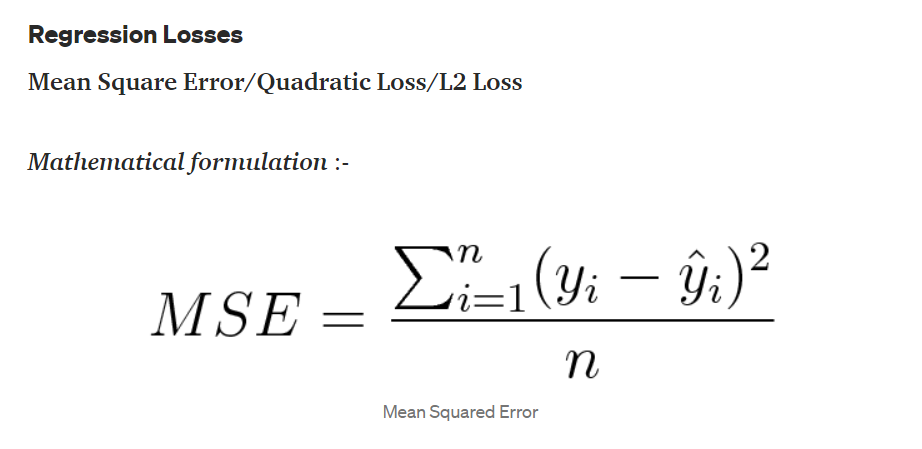

In [18]:
MSE = 0.0
errorPredict = 0
for i in range(0, dfPredict.count()):
  ok, val = predictMethod(dfPredict.collect()[i])
  if ok:
    MSE += (dfPredict.collect()[i]['TKET'] - val)**2 
  else:
    errorPredict += 1

MSE /= (dfPredict.count() - errorPredict)
print("Total query prediction ", dfPredict.count(), "\nTotal error data ", errorPredict, "\nMean Square Error ", MSE)

Predict total score is  7.021306818181818 , real score is  7.0
Predict total score is  5.177777777777778 , real score is  5.0
Predict total score is  6.443262411347518 , real score is  6.5
Predict total score is  8.436440677966102 , real score is  8.5
Predict total score is  7.021306818181818 , real score is  7.5
Predict total score is  2.5 , real score is  2.5
Predict total score is  7.852409638554217 , real score is  8.0
Predict total score is  7.021306818181818 , real score is  7.0
Predict total score is  7.021306818181818 , real score is  6.5
Predict total score is  6.443262411347518 , real score is  6.5
Predict total score is  7.852409638554217 , real score is  8.0
Predict total score is  7.140186915887851 , real score is  7.5
Predict total score is  7.852409638554217 , real score is  7.5
Predict total score is  5.368544600938967 , real score is  5.0
Predict total score is  6.08235294117647 , real score is  6.5
Predict total score is  8.436440677966102 , real score is  9.0
Predict